In [2]:
import re

def read_kurucz_model(file_path):
    """
    Reads a Kurucz stellar atmospheric model grid file and returns a dictionary with parsed data.
    Extracts [Fe/H] and [α/Fe] values from the filename.
    
    Parameters:
    file_path (str): Path to the Kurucz model file.
    
    Returns:
    dict: A dictionary containing the parsed header, abundance data, and atmospheric structure.
    """
    # Parse [Fe/H] and [α/Fe] from filename
    filename = file_path.split('/')[-1]
    
    # More robust regex patterns for metal content values
    feh_pattern = r'feh([+-]?\d+\.?\d*)'
    afe_pattern = r'afe([+-]?\d+\.?\d*)'
    
    feh_match = re.search(feh_pattern, filename)
    afe_match = re.search(afe_pattern, filename)
    
    feh = float(feh_match.group(1)) if feh_match else None
    afe = float(afe_match.group(1)) if afe_match else None
    
    model = {
        'teff': None,
        'gravity': None,
        'title': None,
        'feh': feh,  # Add [Fe/H] from filename
        'afe': afe,  # Add [α/Fe] from filename
        'filename': filename,
        'opacity_ifop': [],
        'convection': {'status': 'OFF', 'parameters': []},
        'turbulence': {'status': 'OFF', 'parameters': []},
        'abundance_scale': None,
        'abundance_changes': {},
        # Directly index the columns we're interested in
        'RHOX': [],
        'T': [],
        'P': [],
        'XNE': [],
        'ABROSS': [],
        'ACCRAD': [],
        'VTURB': [],
        # Store original data columns for reference
        'data_columns': []
    }

    with open(file_path, 'r') as f:
        # Read lines until TEFF line is found
        line = ''
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith('TEFF'):
                break
        
        # Parse TEFF and GRAVITY
        parts = line.split()
        model['teff'] = float(parts[1])
        model['gravity'] = float(parts[3].strip())
        
        # Read TITLE
        line = f.readline().strip()
        model['title'] = line.split('TITLE')[1].strip() if 'TITLE' in line else line
        
        # Parse OPACITY line
        line = f.readline().strip()
        parts = line.split()
        model['opacity_ifop'] = list(map(int, parts[2:22]))  # 20 opacity flags
        
        # Parse CONVECTION and TURBULENCE line
        line = f.readline().strip()
        parts = line.split()
        conv_idx = parts.index('CONVECTION')
        turb_idx = parts.index('TURBULENCE')
        
        model['convection']['status'] = parts[conv_idx + 1]
        model['convection']['parameters'] = list(map(float, parts[conv_idx + 2:turb_idx]))
        
        model['turbulence']['status'] = parts[turb_idx + 1]
        model['turbulence']['parameters'] = list(map(float, parts[turb_idx + 2:]))
        
        # Parse ABUNDANCE SCALE
        line = f.readline().strip()
        parts = line.split()
        model['abundance_scale'] = float(parts[2])
        
        # Parse ABUNDANCE CHANGE lines
        line = f.readline().strip()
        while line.startswith('ABUNDANCE CHANGE'):
            parts = line.split()
            for i in range(2, len(parts), 2):
                elem_num = int(parts[i])
                abundance = float(parts[i+1])
                model['abundance_changes'][elem_num] = abundance
            line = f.readline().strip()
        
        # Skip until READ DECK6 line
        while not line.startswith('READ DECK6'):
            line = f.readline().strip()
        
        # Parse READ DECK6 parameters
        parts = line.split()
        num_depth_points = int(parts[2])
        model['data_columns'] = parts[3:]  # Expected columns
        
        # Define the target columns we're interested in
        target_columns = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB']
        
        # The READ DECK6 line specifies 7 columns, but 
        # the data rows might contain additional values (extra columns)
        
        # Read atmospheric structure data
        for _ in range(num_depth_points):
            line = f.readline()
            values = list(map(float, line.strip().split()))
            
            # The first 7 values correspond to RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB
            # regardless of how many extra columns there are
            if len(values) >= 7:
                model['RHOX'].append(values[0])
                model['T'].append(values[1])
                model['P'].append(values[2])
                model['XNE'].append(values[3])
                model['ABROSS'].append(values[4])
                model['ACCRAD'].append(values[5])
                model['VTURB'].append(values[6])
                
                # Store any extra columns as a list
                if len(values) > 7:
                    if 'extra_columns' not in model:
                        model['extra_columns'] = []
                    model['extra_columns'].append(values[7:])
    
    return model

# Test with the provided paste.txt file
model_data = read_kurucz_model('/home/jdli/xiasangju/kurucz1/data/C3K_atmosphere/atm_vturb=3.0/at12_feh-0.25_afe-0.2_t02500g1.50.atm')
print(f"Effective Temperature (TEFF): {model_data['teff']} K")
print(f"Surface Gravity (log g): {model_data['gravity']}")
print(f"[Fe/H]: {model_data.get('feh', 'Not found in filename')}")
print(f"[α/Fe]: {model_data.get('afe', 'Not found in filename')}")
print(f"Number of data points: {len(model_data['RHOX'])}")

# Print first few rows of the atmospheric structure
for i in range(3):
    print(f"Layer {i+1}:", {
        'RHOX': model_data['RHOX'][i],
        'T': model_data['T'][i], 
        'P': model_data['P'][i],
        'XNE': model_data['XNE'][i],
        'ABROSS': model_data['ABROSS'][i],
        'ACCRAD': model_data['ACCRAD'][i],
        'VTURB': model_data['VTURB'][i]
    })
    
    # Show any extra columns if present
    if 'extra_columns' in model_data and model_data['extra_columns']:
        print(f"  Extra columns: {model_data['extra_columns'][i]}")

Effective Temperature (TEFF): 2500.0 K
Surface Gravity (log g): 1.5
[Fe/H]: -0.25
[α/Fe]: -0.2
Number of data points: 80
Layer 1: {'RHOX': 0.00553763082, 'T': 1194.3, 'P': 0.1752, 'XNE': 2260.0, 'ABROSS': 2.404e-05, 'ACCRAD': 0.0008589, 'VTURB': 300000.0}
  Extra columns: [0.0, 0.0]
Layer 2: {'RHOX': 0.00711308679, 'T': 1213.9, 'P': 0.2251, 'XNE': 3607.0, 'ABROSS': 3.233e-05, 'ACCRAD': 0.000833, 'VTURB': 300000.0}
  Extra columns: [0.0, 0.0]
Layer 3: {'RHOX': 0.00876631556, 'T': 1227.9, 'P': 0.2774, 'XNE': 5086.0, 'ABROSS': 3.939e-05, 'ACCRAD': 0.0008072, 'VTURB': 300000.0}
  Extra columns: [0.0, 0.0]


In [ ]:
import numpy as np

def compute_tau(RHOX, ABROSS):
    """
    Compute the optical depth (tau) from the column mass (RHOX) 
    and the Rosseland mean opacity (ABROSS) using trapezoidal integration.
    
    Parameters:
        RHOX (numpy.ndarray): Array of column mass values.
        ABROSS (numpy.ndarray): Array of opacity values.
    
    Returns:
        numpy.ndarray: Cumulative optical depth (tau) computed from the data.
    """
    # Ensure the arrays are numpy arrays and have the same length
    RHOX = np.asarray(RHOX)
    ABROSS = np.asarray(ABROSS)
    
    # Initialize the tau array; tau[0] is typically set to 0 at the top of the atmosphere
    tau = np.zeros_like(RHOX)
    
    # Use a cumulative trapezoidal integration to compute tau
    # tau[i] = tau[i-1] + 0.5 * (ABROSS[i] + ABROSS[i-1]) * (RHOX[i] - RHOX[i-1])
    for i in range(1, len(RHOX)):
        dRHOX = RHOX[i] - RHOX[i-1]
        tau[i] = tau[i-1] + 0.5 * (ABROSS[i] + ABROSS[i-1]) * dRHOX
    
    return tau

tau = compute_tau(model_data['RHOX'], model_data['ABROSS'])
print(f"Optical depth at the surface: {tau[0]}")

Optical depth at the surface: 0.0


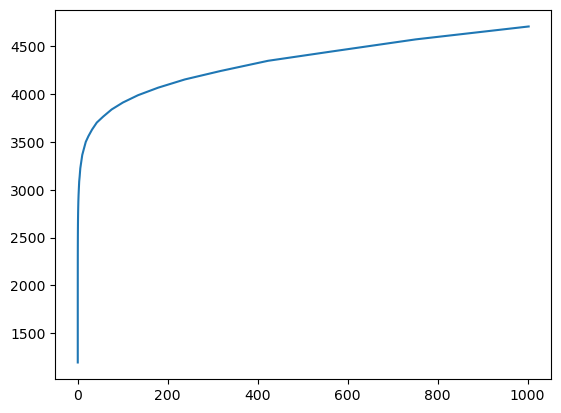

In [7]:
from matplotlib import pyplot as plt

plt.plot(tau, model_data['T'])

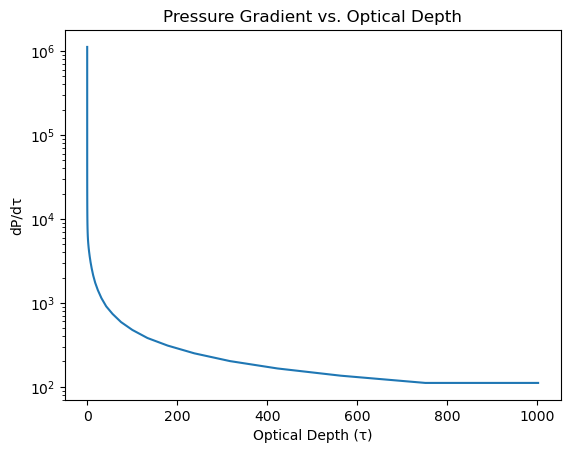

In [10]:
def calculate_gradient_numpy(x, y):
    """
    Calculate the differential gradient (dy/dx) for given x and y arrays using NumPy.
    
    Parameters:
        x (numpy.ndarray): Independent variable
        y (numpy.ndarray): Dependent variable
        
    Returns:
        numpy.ndarray: Gradient dy/dx with same shape as input
    """
    import numpy as np
    
    # Convert inputs to numpy arrays if they aren't already
    if not isinstance(x, np.ndarray):
        x = np.array(x, dtype=np.float32)
    if not isinstance(y, np.ndarray):
        y = np.array(y, dtype=np.float32)
    
    # Ensure x and y have the same shape
    if x.shape != y.shape:
        raise ValueError(f"x and y must have the same shape. Got x: {x.shape}, y: {y.shape}")
    
    # Calculate the differences (forward difference)
    dx = np.diff(x, axis=-1)
    dy = np.diff(y, axis=-1)
    
    # Calculate the gradient dy/dx
    gradient = dy / (dx + 1e-10)  # Add small epsilon to avoid division by zero
    
    # For the last point, use the last calculated gradient
    # This pads the gradient array to match the input shape
    if len(x.shape) == 1:
        gradient = np.concatenate([gradient, gradient[-1:]])
    else:
        # For batched data, pad along the appropriate dimension
        gradient = np.concatenate([gradient, gradient[:, -1:]], axis=1)
    
    return gradient

# Example usage:
dP_dtau = calculate_gradient_numpy(tau, model_data['P'])
plt.plot(tau, dP_dtau)
plt.xlabel('Optical Depth (τ)')
plt.ylabel('dP/dτ')
plt.title('Pressure Gradient vs. Optical Depth')
plt.yscale('log')

In [12]:
g = np.power(10., model_data['gravity']) # cm/s^2
g_kappa = g / model_data['ABROSS'] 

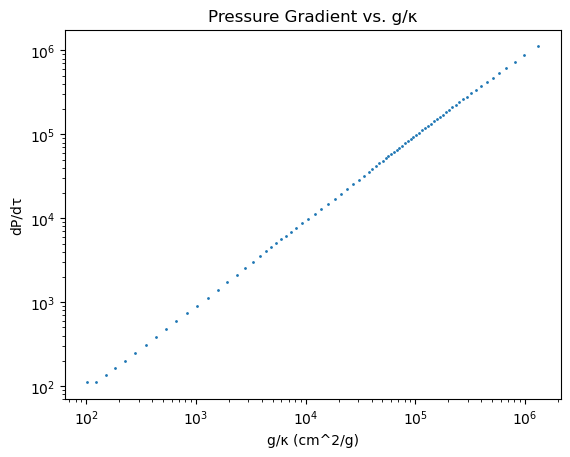

In [14]:
plt.scatter(g_kappa, dP_dtau, s=1)
plt.xlabel('g/κ (cm^2/g)')
plt.ylabel('dP/dτ')
plt.title('Pressure Gradient vs. g/κ')
plt.yscale('log')
plt.xscale('log')

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import re

class KuruczDataset(Dataset):
    """
    Dataset for Kurucz stellar atmosphere models with enhanced normalization handling.
    """
    def __init__(self, data_dir, file_pattern='*.atm', max_depth_points=80, device='cpu'):
        self.data_dir = data_dir
        self.file_paths = glob.glob(os.path.join(data_dir, file_pattern))
        self.max_depth_points = max_depth_points
        self.device = device
        self.norm_params = {}
        
        # Load and process all files
        self.models = []
        for file_path in self.file_paths:
            try:
                model = read_kurucz_model(file_path)
                self.models.append(model)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if len(self.models) == 0:
            raise ValueError(f"No valid model files found in {data_dir} with pattern {file_pattern}")
        
        # Extract input and output features
        self.prepare_data()
        
        # Calculate normalization parameters
        self.setup_normalization()
        
        # Apply normalization to all data
        self.normalize_all_data()

    def prepare_data(self):
        """Prepare data tensors from the loaded models"""
        # Input features: teff, gravity, feh, afe
        self.teff_list = []
        self.gravity_list = []
        self.feh_list = []
        self.afe_list = []
        
        # Output features: RHOX, T, P, XNE, ABROSS, ACCRAD
        self.rhox_list = []
        self.t_list = []
        self.p_list = []
        self.xne_list = []
        self.abross_list = []
        self.accrad_list = []
        
        # Process each model
        for model in self.models:
            # Pad or truncate depth profiles to max_depth_points
            rhox = self.pad_sequence(model['RHOX'], self.max_depth_points)
            t = self.pad_sequence(model['T'], self.max_depth_points)
            p = self.pad_sequence(model['P'], self.max_depth_points)
            xne = self.pad_sequence(model['XNE'], self.max_depth_points)
            abross = self.pad_sequence(model['ABROSS'], self.max_depth_points)
            accrad = self.pad_sequence(model['ACCRAD'], self.max_depth_points)
            
            # Store input parameters
            self.teff_list.append(model['teff'])
            self.gravity_list.append(model['gravity'])
            self.feh_list.append(model['feh'] if model['feh'] is not None else 0.0)
            self.afe_list.append(model['afe'] if model['afe'] is not None else 0.0)
            
            # Store output parameters
            self.rhox_list.append(rhox)
            self.t_list.append(t)
            self.p_list.append(p)
            self.xne_list.append(xne)
            self.abross_list.append(abross)
            self.accrad_list.append(accrad)
        
        # Convert to tensors
        self.original = {
            'teff': torch.tensor(self.teff_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'gravity': torch.tensor(self.gravity_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'feh': torch.tensor(self.feh_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'afe': torch.tensor(self.afe_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'RHOX': torch.tensor(self.rhox_list, dtype=torch.float32, device=self.device),
            'T': torch.tensor(self.t_list, dtype=torch.float32, device=self.device),
            'P': torch.tensor(self.p_list, dtype=torch.float32, device=self.device),
            'XNE': torch.tensor(self.xne_list, dtype=torch.float32, device=self.device),
            'ABROSS': torch.tensor(self.abross_list, dtype=torch.float32, device=self.device),
            'ACCRAD': torch.tensor(self.accrad_list, dtype=torch.float32, device=self.device)
        }

    def setup_normalization(self):
        """Calculate normalization parameters for each feature"""
        # 1. Effective temperature (Teff) - log normalization with robust bounds
        teff_data = self.original['teff']
        log_teff = torch.log10(teff_data + 1e-30)
        self.norm_params['teff'] = {
            'mean': log_teff.mean(),
            'std': log_teff.std(),
            'min': log_teff.min(),
            'max': log_teff.max(),
            'log_scale': True
        }
        
        # 2. Surface gravity (log g) - already in log scale, use min-max
        gravity_data = self.original['gravity']
        self.norm_params['gravity'] = {
            'min': gravity_data.min(),
            'max': gravity_data.max(),
            'log_scale': False,
            'scale_type': 'min_max'
        }
        
        # 3. Metallicity [Fe/H] - min-max scaling
        feh_data = self.original['feh']
        self.norm_params['feh'] = {
            'min': feh_data.min(),
            'max': feh_data.max(),
            'log_scale': False,
            'scale_type': 'min_max'
        }
        
        # 4. Alpha enhancement [α/Fe] - min-max scaling
        afe_data = self.original['afe']
        self.norm_params['afe'] = {
            'min': afe_data.min(),
            'max': afe_data.max(),
            'log_scale': False,
            'scale_type': 'min_max'
        }
        
        # 5. Temperature (T) - simple scaling
        t_data = self.original['T']
        self.norm_params['T'] = {
            'scale': 1e4,  # Scale to order of magnitude ~1
            'min': t_data.min(),
            'max': t_data.max(),
            'log_scale': False,
            'scale_type': 'linear'
        }
        
        # 6. For parameters that need log normalization
        for param in ['RHOX', 'P', 'XNE', 'ABROSS', 'ACCRAD']:
            param_data = self.original[param]
            
            # Add small epsilon to avoid log(0)
            log_data = torch.log10(param_data + 1e-30)
            
            # Calculate statistics for each parameter
            param_min = log_data.min(dim=0).values
            param_max = log_data.max(dim=0).values
            
            # Store normalization parameters
            self.norm_params[param] = {
                'min': param_min,
                'max': param_max,
                'log_scale': True,
                'scale_type': 'min_max'
            }

    def normalize_all_data(self):
        """Apply normalization to all data tensors"""
        # Normalize input parameters
        self.teff = self.normalize('teff', self.original['teff'])
        self.gravity = self.normalize('gravity', self.original['gravity'])
        self.feh = self.normalize('feh', self.original['feh'])
        self.afe = self.normalize('afe', self.original['afe'])
        
        # Normalize output parameters
        self.RHOX = self.normalize('RHOX', self.original['RHOX'])
        self.T = self.normalize('T', self.original['T'])
        self.P = self.normalize('P', self.original['P'])
        self.XNE = self.normalize('XNE', self.original['XNE'])
        self.ABROSS = self.normalize('ABROSS', self.original['ABROSS'])
        self.ACCRAD = self.normalize('ACCRAD', self.original['ACCRAD'])

    def normalize(self, param_name, data):
        """
        Enhanced normalization with parameter-specific approaches.

        Parameters:
            param_name (str): Name of the parameter to normalize
            data (torch.Tensor): Data to normalize

        Returns:
            torch.Tensor: Normalized data
        """
        params = self.norm_params[param_name]

        if param_name == 'teff':
            # Log normalization for effective temperature
            log_data = torch.log10(data + 1e-30)
            # Min-max normalization for better gradient flow
            return (log_data - params['min']) / (params['max'] - params['min'])

        elif param_name == 'T':
            # Simple linear scaling for temperature
            return data / params['scale']

        elif params.get('scale_type') == 'min_max':
            # Min-Max scaling
            return (data - params['min']) / (params['max'] - params['min'])

        elif params.get('log_scale', False):
            # Log normalization + min-max scaling
            log_data = torch.log10(data + 1e-30)
            return (log_data - params['min']) / (params['max'] - params['min'])

        else:
            raise ValueError(f"Unknown normalization approach for parameter: {param_name}")

    def denormalize(self, param_name, normalized_data):
        """
        Enhanced denormalization that perfectly reverses the normalization.

        Parameters:
            param_name (str): Name of the parameter to denormalize
            normalized_data (torch.Tensor): Normalized data to convert back

        Returns:
            torch.Tensor: Denormalized data with gradients preserved
        """
        params = self.norm_params[param_name]

        if param_name == 'teff':
            # Reverse the min-max normalization on log scale
            log_data = normalized_data * (params['max'] - params['min']) + params['min']
            # Convert back from log scale
            denormalized_data = torch.pow(10.0, log_data) - 1e-30

        elif param_name == 'T':
            # Reverse linear scaling for temperature
            denormalized_data = normalized_data * params['scale']

        elif params.get('scale_type') == 'min_max':
            # Reverse Min-Max scaling
            denormalized_data = normalized_data * (params['max'] - params['min']) + params['min']

        elif params.get('log_scale', False):
            # Reverse min-max scaling of log values
            log_data = normalized_data * (params['max'] - params['min']) + params['min']
            # Convert back from log scale
            denormalized_data = torch.pow(10.0, log_data) - 1e-30

        else:
            raise ValueError(f"Unknown denormalization approach for parameter: {param_name}")

        # Ensure gradient propagation is maintained and data stays on the correct device
        return denormalized_data.requires_grad_().to(self.device)

    def pad_sequence(self, values, target_length):
        """Pad a sequence to the target length"""
        if len(values) >= target_length:
            return values[:target_length]
        
        # Pad with the last value
        padding_needed = target_length - len(values)
        return values + [values[-1]] * padding_needed
    
    def __len__(self):
        return len(self.teff)
    
    def __getitem__(self, idx):
        """Return normalized input features and output features"""
        # Input features (already normalized)
        input_features = torch.cat([
            self.teff[idx],
            self.gravity[idx],
            self.feh[idx],
            self.afe[idx]
        ], dim=0)
        
        # Output features (already normalized)
        output_features = torch.stack([
            self.RHOX[idx],
            self.T[idx],
            self.P[idx],
            self.XNE[idx],
            self.ABROSS[idx],
            self.ACCRAD[idx]
        ], dim=1)
        
        return input_features, output_features
    
    def inverse_transform_inputs(self, inputs):
        """Transform normalized inputs back to physical units"""
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)  # Add batch dimension if needed
            
        # Split the input tensor back into individual parameters
        teff = inputs[:, 0:1]
        gravity = inputs[:, 1:2]
        feh = inputs[:, 2:3]
        afe = inputs[:, 3:4]
        
        # Denormalize each parameter
        teff_denorm = self.denormalize('teff', teff)
        gravity_denorm = self.denormalize('gravity', gravity)
        feh_denorm = self.denormalize('feh', feh)
        afe_denorm = self.denormalize('afe', afe)
        
        # Return as a dictionary for clarity
        return {
            'teff': teff_denorm,
            'gravity': gravity_denorm,
            'feh': feh_denorm,
            'afe': afe_denorm
        }
    
    def inverse_transform_outputs(self, outputs):
        """Transform normalized outputs back to physical units"""
        batch_size, depth_points, num_features = outputs.shape
        
        # Initialize containers for denormalized data
        result = {
            'RHOX': None,
            'T': None,
            'P': None,
            'XNE': None,
            'ABROSS': None,
            'ACCRAD': None
        }
        
        # Get column names
        columns = list(result.keys())
        
        # Denormalize each feature
        for i, param_name in enumerate(columns):
            # Extract the i-th feature for all samples and depths
            feature_data = outputs[:, :, i]
            # Denormalize
            result[param_name] = self.denormalize(param_name, feature_data)
        
        return result
    
    # Add these methods to your KuruczDataset class
    def save_dataset(self, filepath):
        """
        Save the dataset, including all normalized data and normalization parameters.
        
        Parameters:
            filepath (str): Path to save the dataset
        """
        # Create a dictionary with all necessary data
        save_dict = {
            'norm_params': self.norm_params,
            'max_depth_points': self.max_depth_points,
            'data': {
                # Input features
                'teff': self.teff,
                'gravity': self.gravity,
                'feh': self.feh,
                'afe': self.afe,
                # Output features
                'RHOX': self.RHOX,
                'T': self.T,
                'P': self.P,
                'XNE': self.XNE,
                'ABROSS': self.ABROSS,
                'ACCRAD': self.ACCRAD,
                # Original data (optional, can be commented out to save space)
                'original': self.original
            }
        }
        
        # Save to file
        torch.save(save_dict, filepath)
        print(f"Dataset saved to {filepath}")

    def load_dataset(filepath, device='cpu'):
        """
        Load a saved dataset.
        
        Parameters:
            filepath (str): Path to the saved dataset
            device (str): Device to load the data to ('cpu' or 'cuda')
            
        Returns:
            KuruczDataset: Loaded dataset
        """
        # Create an empty dataset
        dataset = KuruczDataset.__new__(KuruczDataset)
        
        # Load the saved data
        save_dict = torch.load(filepath, map_location=device)
        
        # Restore attributes
        dataset.norm_params = save_dict['norm_params']
        dataset.max_depth_points = save_dict['max_depth_points']
        dataset.device = device
        
        # Move data to the specified device
        for key, tensor in save_dict['data'].items():
            if isinstance(tensor, dict):
                # Handle nested dictionaries (like 'original')
                setattr(dataset, key, {k: v.to(device) for k, v in tensor.items()})
            else:
                setattr(dataset, key, tensor.to(device))
        
        # Initialize empty models list (not needed after loading)
        dataset.models = []
        
        return dataset


def custom_loss(pred, target, dataset, weights=None):
    """
    Custom loss function with optional weighting for different atmospheric parameters.
    
    Parameters:
        pred (torch.Tensor): Model predictions, shape (batch_size, depth_points, output_size)
        target (torch.Tensor): Target values, shape (batch_size, depth_points, output_size)
        dataset (KuruczDataset): Dataset for denormalization
        weights (dict, optional): Weights for each parameter
        
    Returns:
        torch.Tensor: Weighted loss value
    """
    if weights is None:
        # Default weights prioritize temperature and pressure
        weights = {
            'RHOX': 1.0,
            'T': 2.0,    # Higher weight for temperature
            'P': 1.5,    # Higher weight for pressure
            'XNE': 1.0,
            'ABROSS': 1.0,
            'ACCRAD': 1.0
        }
    
    # Compute MSE loss for each output feature
    mse_loss = torch.nn.MSELoss(reduction='none')
    param_losses = {}
    
    columns = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    
    total_loss = 0
    for i, param in enumerate(columns):
        # Extract the i-th feature for prediction and target
        pred_feature = pred[:, :, i]
        target_feature = target[:, :, i]
        
        # Compute MSE
        feature_loss = mse_loss(pred_feature, target_feature)
        
        # Average over depth points
        feature_loss = feature_loss.mean(dim=1).mean()
        
        # Apply weight
        weighted_loss = feature_loss * weights[param]
        param_losses[param] = weighted_loss
        total_loss += weighted_loss
    
    return total_loss, param_losses

def create_dataloader(data_dir, batch_size=32, num_workers=4, file_pattern='*.atm', 
                     max_depth_points=80, device='cpu'):
    """
    Create DataLoader for Kurucz atmospheric models.
    
    Parameters:
    data_dir (str): Directory containing the model files
    batch_size (int): Batch size for the DataLoader
    num_workers (int): Number of worker processes for the DataLoader
    file_pattern (str): Pattern to match model files
    max_depth_points (int): Maximum number of depth points to use (for padding)
    device (str): Device to use for tensor operations
    
    Returns:
    tuple: (DataLoader, Dataset) for the Kurucz models
    """
    dataset = KuruczDataset(data_dir, file_pattern, max_depth_points, device)
    
    # Create DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if device=='cuda' else False,
    )
    
    return dataloader, dataset


In [ ]:
# Directory containing Kurucz model files
data_dir = "/home/jdli/xiasangju/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/"

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Create dataloader
dataloader, dataset = create_dataloader(
    data_dir=data_dir,
    batch_size=32,
    max_depth_points=80,
    device=device
)

dataset.save_dataset("/home/jdli/xiasangju/kurucz1/data/kurucz_dataset.pt")


Error loading /home/jdli/xiasangju/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.6_t05000g0.00.atm: could not convert string to float: '1.362E+14-3.951E+00'


In [29]:

def load_dataset(filepath, device='cpu'):
    """
    Load a saved dataset.
    
    Parameters:
        filepath (str): Path to the saved dataset
        device (str): Device to load the data to ('cpu' or 'cuda')
        
    Returns:
        KuruczDataset: Loaded dataset
    """
    # Create an empty dataset
    dataset = KuruczDataset.__new__(KuruczDataset)
    
    # Load the saved data
    save_dict = torch.load(filepath, map_location=device)
    
    # Restore attributes
    dataset.norm_params = save_dict['norm_params']
    dataset.max_depth_points = save_dict['max_depth_points']
    dataset.device = device
    
    # Move data to the specified device
    for key, value in save_dict['data'].items():
        if key == 'original':
            # Handle the 'original' dictionary specially
            original_dict = {}
            for k, v in value.items():
                if isinstance(v, torch.Tensor):
                    original_dict[k] = v.to(device)
                else:
                    original_dict[k] = v
            setattr(dataset, key, original_dict)
        else:
            # Normal tensor values
            setattr(dataset, key, value.to(device))
    
    # Initialize empty models list (not needed after loading)
    dataset.models = []
    
    return dataset

# This function creates a fresh dataloader from a saved dataset
def create_dataloader_from_saved(filepath, batch_size=32, num_workers=4, device='cpu'):
    """
    Create a DataLoader from a saved dataset.
    
    Parameters:
        filepath (str): Path to the saved dataset
        batch_size (int): Batch size for the DataLoader
        num_workers (int): Number of worker processes
        device (str): Device to load the data to ('cpu' or 'cuda')
        
    Returns:
        tuple: (DataLoader, Dataset)
    """
    # Load the dataset
    dataset = load_dataset(filepath, device)
    
    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if device=='cuda' else False,
    )
    
    return dataloader, dataset

In [30]:
file_path = "/home/jdli/xiasangju/kurucz1/data/kurucz_dataset.pt"
device = torch.device("cpu")
dataset = load_dataset(file_path, device)